In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    
# make cudnn deterministic
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Read dataset from file (Dataset-English_to_French.txt)
# The file defines a variable "english_to_french" as a list of (English, French) tuples.
with open("Dataset-English_to_French.txt", "r", encoding="utf-8") as f:
    data_str = f.read()
exec(data_str)  # This defines the variable english_to_french in the namespace

# Build word-level vocabulary from both English and French sentences
all_words = []
for eng, fr in english_to_french:
    all_words.extend(eng.split())
    all_words.extend(fr.split())
vocab = sorted(list(set(all_words)))
# Define special tokens: SOS (start) and EOS (end)
SOS_token = 0
EOS_token = 1
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for i, word in enumerate(vocab):
    word_to_index[word] = i + 2
index_to_word = {i: word for word, i in word_to_index.items()}

# Print vocabulary size for confirmation
print("Vocabulary size:", len(word_to_index))

# Output some samples to verify the dataset
print("\nSample data from english_to_french:")
for i, sample in enumerate(english_to_french[:5]):
    print(f"Sample {i+1}: {sample}")

Vocabulary size: 511

Sample data from english_to_french:
Sample 1: ('I am cold', "J'ai froid")
Sample 2: ('You are tired', 'Tu es fatigué')
Sample 3: ('He is hungry', 'Il a faim')
Sample 4: ('She is happy', 'Elle est heureuse')
Sample 5: ('We are friends', 'Nous sommes amis')


In [3]:
# Create a custom Dataset for English-to-French translation (word-based)
class TranslationDataset(Dataset):
    """Custom Dataset for English-to-French translation (word-based)."""
    def __init__(self, data, word_to_index):
        self.data = data
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng, fr = self.data[idx]
        # Tokenize by splitting on whitespace and append EOS token
        input_tensor = torch.tensor([self.word_to_index[word] for word in eng.split()] + [EOS_token], dtype=torch.long)
        target_tensor = torch.tensor([self.word_to_index[word] for word in fr.split()] + [EOS_token], dtype=torch.long)
        return input_tensor, target_tensor

# Instantiate the dataset and dataloader
dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [4]:
# Define the GRU-based Encoder (word-based)
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Embed input token and reshape for GRU (sequence length = 1)
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [5]:
# Define the GRU-based Decoder with Attention (word-based)
class AttnDecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=50, dropout_p=0.1):
        super(AttnDecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.dropout_p = dropout_p
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Attention layer: takes concatenated (embedded, hidden) and outputs attention weights over max_length positions
        self.attn = nn.Linear(hidden_size * 2, max_length)
        # Combine embedded input and context vector into a single hidden vector
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        # Embed input word
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Concatenate embedded input and current hidden state for attention calculation
        attn_input = torch.cat((embedded[0], hidden[0]), 1)  # shape: (1, hidden_size*2)
        attn_weights = torch.softmax(self.attn(attn_input), dim=1)  # shape: (1, max_length)
        
        # Multiply attention weights with encoder_outputs to get context vector
        # encoder_outputs shape: (max_length, hidden_size)
        attn_weights_unsqueezed = attn_weights.unsqueeze(1)  # shape: (1, 1, max_length)
        encoder_outputs_unsqueezed = encoder_outputs.unsqueeze(0)  # shape: (1, max_length, hidden_size)
        context = torch.bmm(attn_weights_unsqueezed, encoder_outputs_unsqueezed)  # shape: (1, 1, hidden_size)
        
        # Combine embedded input and context vector, then feed to GRU
        output = torch.cat((embedded[0], context[0]), 1)  # shape: (1, hidden_size*2)
        output = self.attn_combine(output).unsqueeze(0)  # shape: (1, 1, hidden_size)
        output = torch.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [6]:

# Instantiate models with word-level vocabulary size
input_size = len(word_to_index)
hidden_size = 256
output_size = len(word_to_index)

encoder = EncoderGRU(input_size, hidden_size).to(device)
# Instantiate attention decoder with word-level vocabulary size
attn_decoder = AttnDecoderGRU(hidden_size, output_size, max_length=50, dropout_p=0.1).to(device)

In [7]:
# Training function for one sample pair using Attention
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=50):
    # Remove batch dimension if present
    input_tensor = input_tensor.squeeze(0)
    target_tensor = target_tensor.squeeze(0)
    
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # Initialize encoder_outputs with zeros (size: max_length x hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    # Encoder forward pass: record outputs for attention
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]
            
    # Decoder forward pass: start with SOS token
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    
    for di in range(target_length):
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token:
            break
            
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length, predicted_indices

# Evaluation function for the Attention model (computes token-level accuracy)
def evaluate_attn(encoder, decoder, dataloader, criterion, max_length=50):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    total_samples = 0
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            # Remove batch dimension if present
            input_tensor = input_tensor.squeeze(0).to(device)
            target_tensor = target_tensor.squeeze(0).to(device)
            
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
            loss = 0
            predicted_indices = []
            
            # Encoder pass
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
                if ei < max_length:
                    encoder_outputs[ei] = encoder_output[0, 0]
                    
            decoder_input = torch.tensor([SOS_token], device=device)
            decoder_hidden = encoder_hidden
            for di in range(target_length):
                decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
                topv, topi = decoder_output.topk(1)
                predicted_indices.append(topi.item())
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break
            
            total_loss += loss.item() / target_length
            # Token-level accuracy: compare each predicted token with the target token (position-wise)
            correct = 0
            for i in range(target_length):
                if i < len(predicted_indices) and predicted_indices[i] == target_tensor[i].item():
                    correct += 1
            total_correct += correct
            total_tokens += target_length
            total_samples += 1
    avg_loss = total_loss / total_samples
    token_accuracy = total_correct / total_tokens
    return avg_loss, token_accuracy

In [8]:
# Set up optimizers and loss function for attention model
learning_rate = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

n_epochs = 100
train_losses = []   # List to record training loss per epoch
val_losses = []     # List to record evaluation loss per epoch
val_accuracies = [] # List to record evaluation token-level accuracy per epoch

for epoch in range(n_epochs):
    total_loss = 0
    encoder.train()
    attn_decoder.train()
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        loss, _ = train_attn(input_tensor, target_tensor, encoder, attn_decoder,
                              encoder_optimizer, decoder_optimizer, criterion, max_length=50)
        total_loss += loss
    avg_train_loss = total_loss / len(dataloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate model on the entire dataset
    val_loss, val_accuracy = evaluate_attn(encoder, attn_decoder, dataloader, criterion, max_length=50)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Token Accuracy: {val_accuracy:.4f}')

Epoch 1, Train Loss: 3.6866, Val Loss: 2.6605, Token Accuracy: 0.0369
Epoch 2, Train Loss: 2.4964, Val Loss: 2.4408, Token Accuracy: 0.0369
Epoch 3, Train Loss: 2.8460, Val Loss: 2.3055, Token Accuracy: 0.0369
Epoch 4, Train Loss: 3.0408, Val Loss: 3.7296, Token Accuracy: 0.1260
Epoch 5, Train Loss: 3.2993, Val Loss: 2.9976, Token Accuracy: 0.1382
Epoch 6, Train Loss: 3.1959, Val Loss: 2.8444, Token Accuracy: 0.1290
Epoch 7, Train Loss: 3.0741, Val Loss: 2.7124, Token Accuracy: 0.1429
Epoch 8, Train Loss: 2.9123, Val Loss: 3.0994, Token Accuracy: 0.2442
Epoch 9, Train Loss: 2.8165, Val Loss: 3.0162, Token Accuracy: 0.2780
Epoch 10, Train Loss: 2.6881, Val Loss: 2.3466, Token Accuracy: 0.2366
Epoch 11, Train Loss: 2.5353, Val Loss: 2.6226, Token Accuracy: 0.2934
Epoch 12, Train Loss: 2.5138, Val Loss: 2.0961, Token Accuracy: 0.2857
Epoch 13, Train Loss: 2.2554, Val Loss: 2.1104, Token Accuracy: 0.3410
Epoch 14, Train Loss: 2.1730, Val Loss: 1.9454, Token Accuracy: 0.3871
Epoch 15, Train

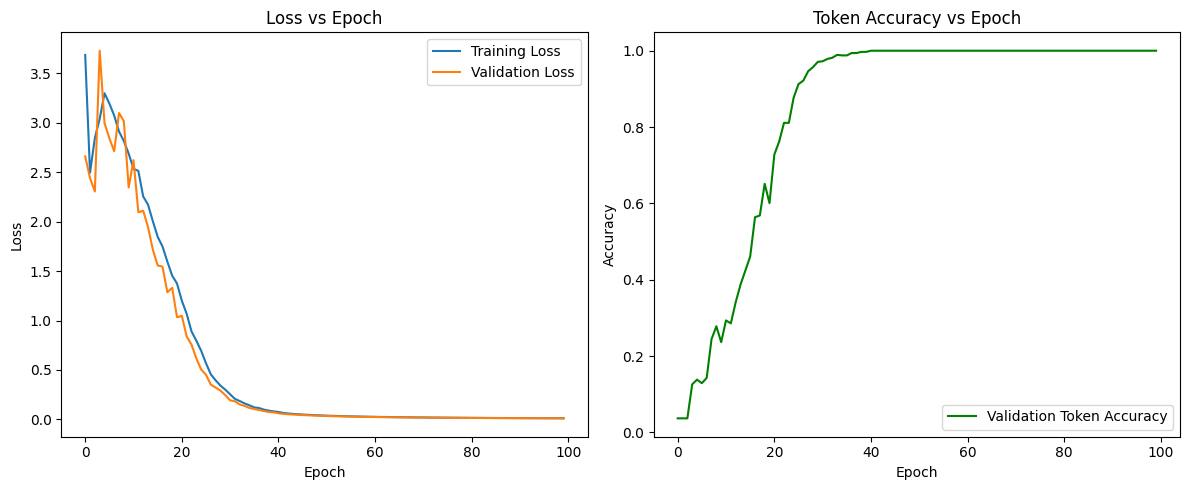

In [9]:
# Plot loss and accuracy curves
epochs = range(n_epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Token Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Token Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('images/p2_GRU_attention_etf_output.png')
plt.show()


Sample Translations (Attention Model):
Original: She dances at the party
Target  : Elle danse à la fête
Predicted: Elle danse à la fête


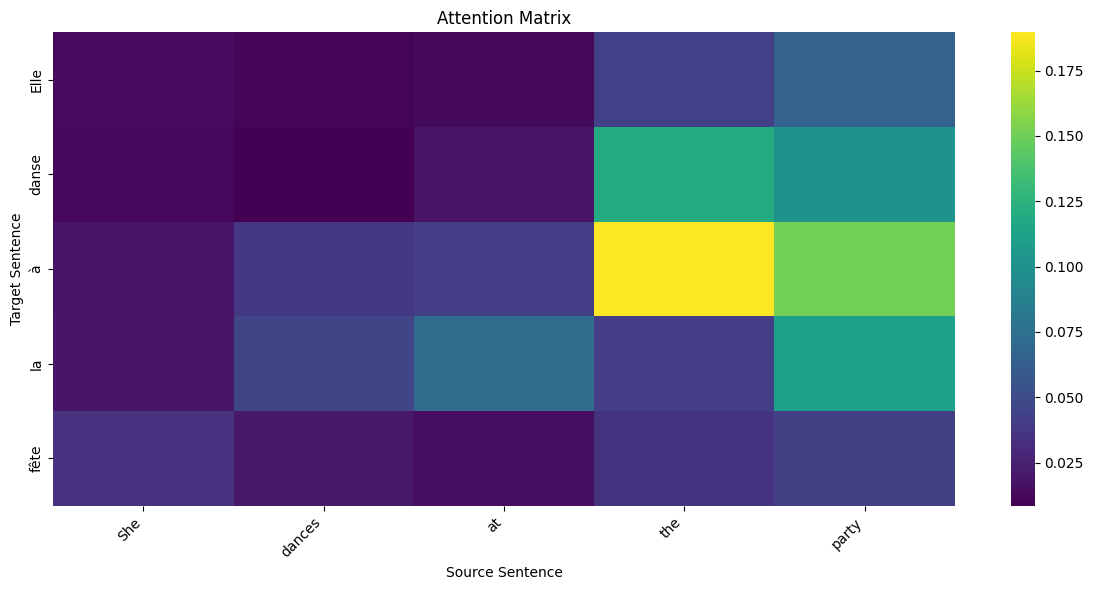

--------------------------------------------------
Original: The sun sets in the evening
Target  : Le soleil se couche le soir
Predicted: Le soleil se couche le soir


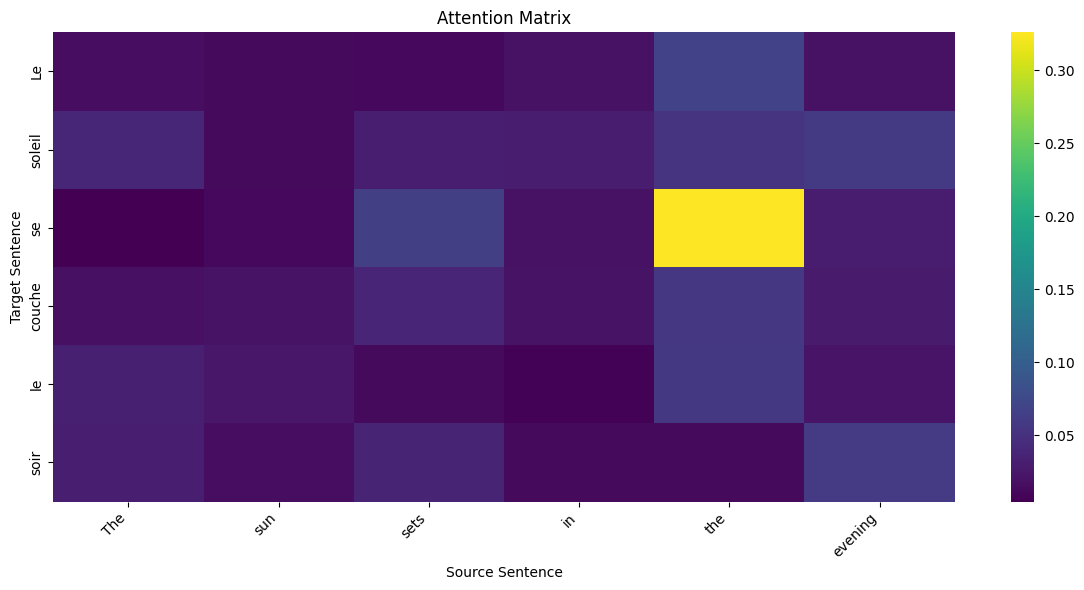

--------------------------------------------------
Original: We celebrate birthdays with cake
Target  : Nous célébrons les anniversaires avec un gâteau
Predicted: Nous célébrons les anniversaires avec un gâteau


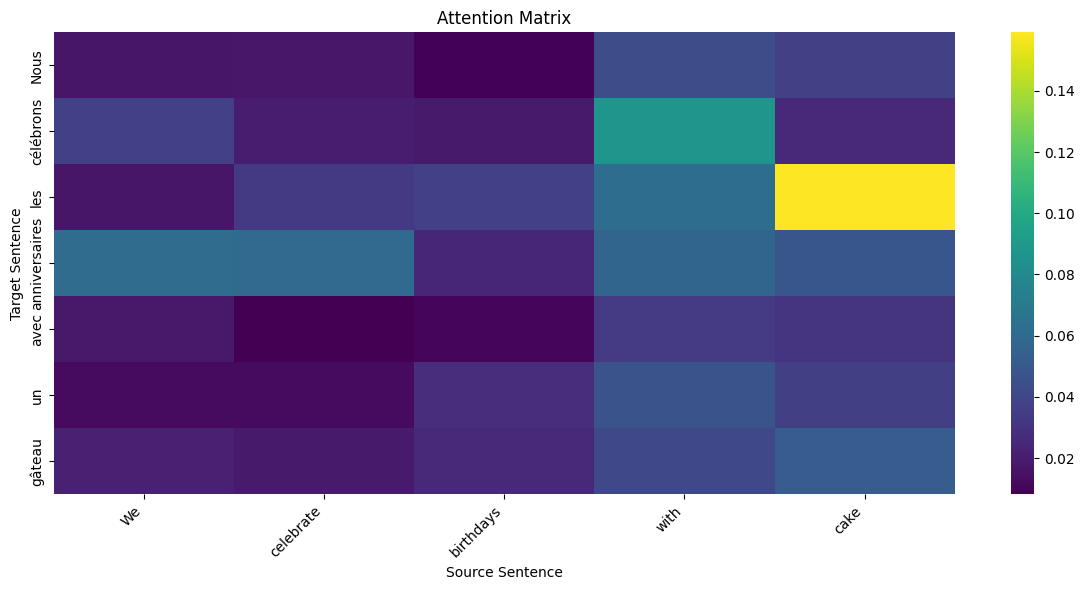

--------------------------------------------------
Original: She teaches English at school
Target  : Elle enseigne l'anglais à l'école
Predicted: Elle enseigne l'anglais à l'école


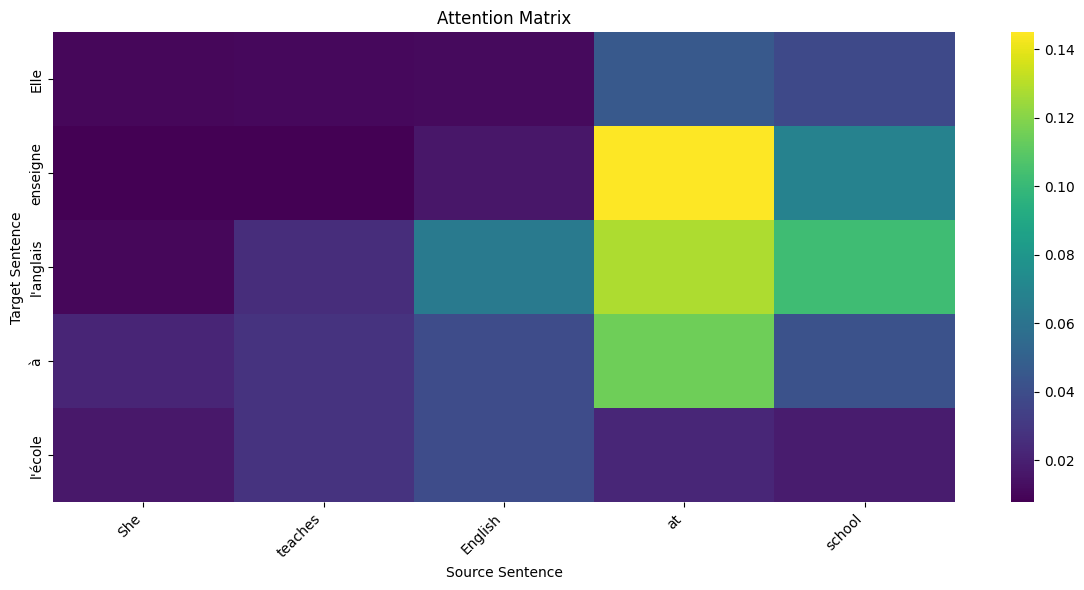

--------------------------------------------------
Original: She catches the bus
Target  : Elle attrape le bus
Predicted: Elle attrape le bus


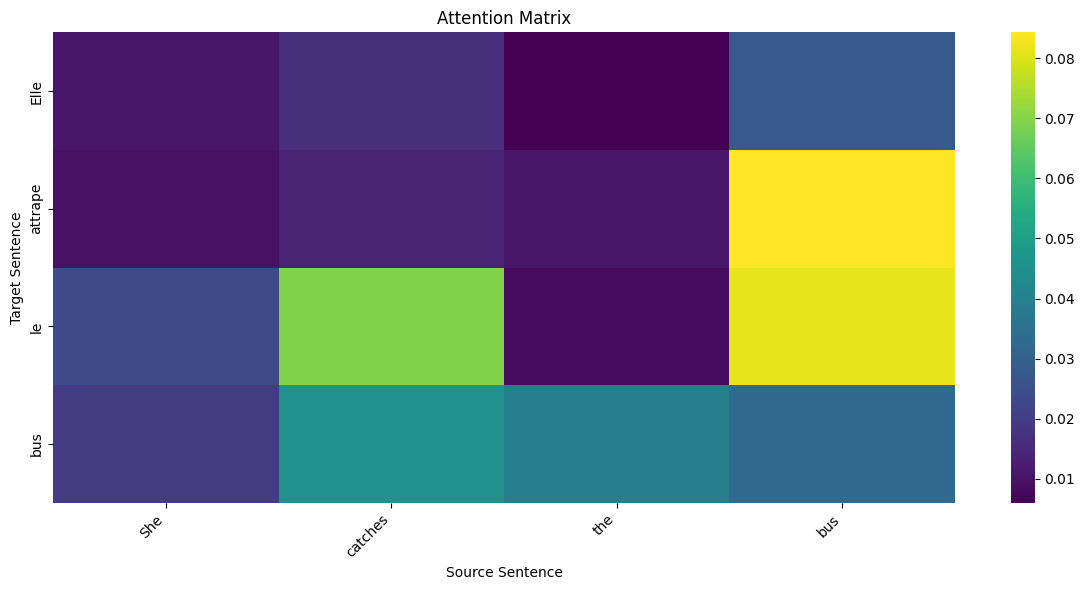

--------------------------------------------------


In [15]:
# Output some sample translations: original, target, and predicted (using attention model)
encoder.eval()
attn_decoder.eval()
num_examples = 5  # Number of examples to display

print("\nSample Translations (Attention Model):")
sample_count = 0
with torch.no_grad():
    for input_tensor, target_tensor in dataloader:
        # Remove batch dimension and move to device
        input_tensor = input_tensor.squeeze(0).to(device)
        target_tensor = target_tensor.squeeze(0).to(device)
        
        encoder_hidden = encoder.initHidden()
        input_length = input_tensor.size(0)
        # Compute encoder outputs for attention
        encoder_outputs = torch.zeros(50, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
            if ei < 50:
                encoder_outputs[ei] = encoder_output[0, 0]
        
        decoder_input = torch.tensor([SOS_token], device=device)
        decoder_hidden = encoder_hidden
        predicted_indices = []
        # List to store attention matrix for each decoding step
        attn_matrices = []

        # Generate translation using attention decoder
        while True:
            decoder_output, decoder_hidden, attn_weights = attn_decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Save current step's attention weights
            attn_matrices.append(attn_weights.cpu().numpy())
            topv, topi = decoder_output.topk(1)
            predicted_indices.append(topi.item())
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token or len(predicted_indices) > 50:
                break

        # Stack all attention weights to form a 2D attention matrix (decoder_steps x max_length)
        attn_matrix = np.concatenate(attn_matrices, axis=0)

        # Convert indices back to words (excluding SOS/EOS for display)
        src_tokens = [index_to_word[idx.item()] for idx in input_tensor if idx.item() not in [SOS_token, EOS_token]]
        tgt_tokens = [index_to_word[idx] for idx in predicted_indices if idx not in [SOS_token, EOS_token]]
        
        # Only slice the attention matrix up to actual lengths
        #    Rows: actual decoding steps = len(tgt_tokens)
        #    Cols: actual encoding steps = len(src_tokens)
        dec_steps = len(tgt_tokens)
        enc_steps = len(src_tokens)
        attn_matrix = attn_matrix[:dec_steps, :enc_steps]
        
        # Prepare text for display
        original_sentence = " ".join(src_tokens)
        target_sentence = " ".join([index_to_word[idx.item()] for idx in target_tensor if idx.item() not in [SOS_token, EOS_token]])
        predicted_sentence = " ".join(tgt_tokens)
        
        # original_sentence = " ".join([index_to_word[idx.item()] for idx in input_tensor if idx.item() not in [SOS_token, EOS_token]])
        # target_sentence = " ".join([index_to_word[idx.item()] for idx in target_tensor if idx.item() not in [SOS_token, EOS_token]])
        # predicted_sentence = " ".join([index_to_word[idx] for idx in predicted_indices if idx not in [SOS_token, EOS_token]])

        print("Original:", original_sentence)
        print("Target  :", target_sentence)
        print("Predicted:", predicted_sentence)

        # Plot the attention matrix heatmap with source & target labels
        plt.figure(figsize=(12, 6))  # 固定图像尺寸，例如 12x6
        sns.heatmap(attn_matrix, cmap="viridis", cbar=True,
                    xticklabels=src_tokens, yticklabels=tgt_tokens)
        plt.xlabel("Source Sentence")
        plt.ylabel("Target Sentence")
        plt.title("Attention Matrix")

        # Rotate x-axis labels for readability
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        filename = f"images/p2_attention_eft_sample_{sample_count+1}.png"
        plt.savefig(filename)
        plt.show()

        print("-" * 50)
        
        sample_count += 1
        if sample_count >= num_examples:
            break